In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Search for all ZIP files in your Drive
!find /content/drive/MyDrive -name "*.zip"


/content/drive/MyDrive/others/file.zip
/content/drive/MyDrive/VGGFace2_balanced_900_albumentations (1).zip


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import numpy as np

In [13]:
zip_path = "/content/drive/MyDrive/VGGFace2_balanced_900_albumentations (1).zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")
print(os.listdir(extract_path))


Dataset unzipped successfully!
['VGGFace2_balanced_900_albumentations']


In [14]:
dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("Classes:", class_names)


Number of classes: 15
Classes: ['Aditi Rao Hydari', 'Adrienne Bailon-Houghton', 'Alberto Núñez Feijóo', 'Aleksander Kwaśniewski', 'Aleksandra Kwaśniewska', 'Alesha Dixon', 'Alex Salmond', 'Alexa Chung', 'Alfredo Pérez Rubalcaba', 'Aléxis Tsípras', 'Amber Heard', 'Amy Adams', 'Andie MacDowell', 'Boris Tadić', 'Bronisław Komorowski']


In [15]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # split 15% for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 11475 images belonging to 15 classes.
Found 2025 images belonging to 15 classes.


In [16]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,   # remove final classifier
    weights='imagenet'
)
base_model.trainable = False  # freeze the convolutional base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,921,551 (11.14 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint(
    "/content/drive/MyDrive/best_mobilenet_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # start with 20, can increase later
    callbacks=[checkpoint_cb, earlystop_cb]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1901 - loss: 2.4419
Epoch 1: val_accuracy improved from -inf to 0.62469, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.1903 - loss: 2.4411 - val_accuracy: 0.6247 - val_loss: 1.3671
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4297 - loss: 1.6352
Epoch 2: val_accuracy improved from 0.62469 to 0.71951, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.4297 - loss: 1.6350 - val_accuracy: 0.7195 - val_loss: 1.0433
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5309 - loss: 1.3869
Epoch 3: val_accuracy improved from 0.71951 to 0.76642, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.5309 - loss: 1.3868 - val_accuracy: 0.7664 - val_loss: 0.8743
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5788 - loss: 1.2421
Epoch 4: val_accuracy improved from 0.76642 to 0.76938, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.5788 - loss: 1.2420 - val_accuracy: 0.7694 - val_loss: 0.7868
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6128 - loss: 1.1359
Epoch 5: val_accuracy improved from 0.76938 to 0.80198, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.6129 - loss: 1.1358 - val_accuracy: 0.8020 - val_loss: 0.7037
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6473 - loss: 1.0584
Epoch 6: val_accuracy improved from 0.80198 to 0.81778, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.6473 - loss: 1.0584 - val_accuracy: 0.8178 - val_loss: 0.6481
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6643 - loss: 0.9979
Epoch 7: val_accuracy did not improve from 0.81778
359/359 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.6644 - loss: 0.9979 - val_accuracy: 0.8123 - val_loss: 0.6309
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6807 - loss: 0.9607
Epoch 8: val_accuracy improved from 0.81778 to 0.83309, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.6807 - loss: 0.9607 - val_accuracy: 0.8331 - val_loss: 0.5916
Epoch 9/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6933 - loss: 0.9083
Epoch 9: val_accuracy did not improve from 0.83309
359/359 ━━━━━━━━━━━━━━━━━━━━ 787s 2s/step - accuracy: 0.6933 - loss: 0.9082 - val_accuracy: 0.8252 - val_loss: 0.5744
Epoch 10/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7104 - loss: 0.8733
Epoch 10: val_accuracy improved from 0.83309 to 0.83951, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.7104 - loss: 0.8733 - val_accuracy: 0.8395 - val_loss: 0.5396
Epoch 11/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7240 - loss: 0.8331
Epoch 11: val_accuracy improved from 0.83951 to 0.85481, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.7240 - loss: 0.8331 - val_accuracy: 0.8548 - val_loss: 0.4973
Epoch 12/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7295 - loss: 0.8088
Epoch 12: val_accuracy did not improve from 0.85481
359/359 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.7295 - loss: 0.8088 - val_accuracy: 0.8489 - val_loss: 0.5007
Epoch 13/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7449 - loss: 0.7703
Epoch 13: val_accuracy improved from 0.85481 to 0.86025, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.7449 - loss: 0.7703 - val_accuracy: 0.8602 - val_loss: 0.4780
Epoch 14/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7489 - loss: 0.7545
Epoch 14: val_accuracy did not improve from 0.86025
359/359 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.7489 - loss: 0.7545 - val_accuracy: 0.8523 - val_loss: 0.4766
Epoch 15/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7515 - loss: 0.7301
Epoch 15: val_accuracy improved from 0.86025 to 0.86568, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.7515 - loss: 0.7301 - val_accuracy: 0.8657 - val_loss: 0.4536
Epoch 16/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7570 - loss: 0.7275
Epoch 16: val_accuracy did not improve from 0.86568
359/359 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.7570 - loss: 0.7275 - val_accuracy: 0.8657 - val_loss: 0.4546
Epoch 17/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7737 - loss: 0.6980
Epoch 17: val_accuracy did not improve from 0.86568
359/359 ━━━━━━━━━━━━━━━━━━━━ 775s 2s/step - accuracy: 0.7737 - loss: 0.6980 - val_accuracy: 0.8509 - val_loss: 0.4500
Epoch 18/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7710 - loss: 0.6758
Epoch 18: val_accuracy improved from 0.86568 to 0.87951, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.7710 - loss: 0.6758 - val_accuracy: 0.8795 - val_loss: 0.4183
Epoch 19/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7770 - loss: 0.6699
Epoch 19: val_accuracy did not improve from 0.87951
359/359 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - accuracy: 0.7770 - loss: 0.6699 - val_accuracy: 0.8691 - val_loss: 0.4205
Epoch 20/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7880 - loss: 0.6444
Epoch 20: val_accuracy did not improve from 0.87951
359/359 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.7880 - loss: 0.6444 - val_accuracy: 0.8677 - val_loss: 0.4185
Restoring model weights from the end of the best epoch: 18.


In [20]:
base_model.trainable = True

# Optional: fine-tune only last few layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5810 - loss: 1.2523
Epoch 1: val_accuracy did not improve from 0.87951
359/359 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.5812 - loss: 1.2519 - val_accuracy: 0.8617 - val_loss: 0.4216
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7196 - loss: 0.8349
Epoch 2: val_accuracy improved from 0.87951 to 0.88642, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 936s 3s/step - accuracy: 0.7196 - loss: 0.8348 - val_accuracy: 0.8864 - val_loss: 0.3190
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7557 - loss: 0.7188
Epoch 3: val_accuracy improved from 0.88642 to 0.89284, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 934s 3s/step - accuracy: 0.7558 - loss: 0.7187 - val_accuracy: 0.8928 - val_loss: 0.2887
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7881 - loss: 0.6308
Epoch 4: val_accuracy improved from 0.89284 to 0.92395, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 936s 3s/step - accuracy: 0.7881 - loss: 0.6308 - val_accuracy: 0.9240 - val_loss: 0.2449
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8123 - loss: 0.5714
Epoch 5: val_accuracy improved from 0.92395 to 0.92741, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.8123 - loss: 0.5714 - val_accuracy: 0.9274 - val_loss: 0.2108
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8288 - loss: 0.5172
Epoch 6: val_accuracy improved from 0.92741 to 0.93827, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 932s 3s/step - accuracy: 0.8288 - loss: 0.5172 - val_accuracy: 0.9383 - val_loss: 0.1922
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8422 - loss: 0.4780
Epoch 7: val_accuracy improved from 0.93827 to 0.93926, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 951s 3s/step - accuracy: 0.8422 - loss: 0.4780 - val_accuracy: 0.9393 - val_loss: 0.1893
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8452 - loss: 0.4460
Epoch 8: val_accuracy improved from 0.93926 to 0.93975, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.8452 - loss: 0.4460 - val_accuracy: 0.9398 - val_loss: 0.1738
Epoch 9/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8528 - loss: 0.4295
Epoch 9: val_accuracy did not improve from 0.93975
359/359 ━━━━━━━━━━━━━━━━━━━━ 926s 3s/step - accuracy: 0.8528 - loss: 0.4295 - val_accuracy: 0.9368 - val_loss: 0.1797
Epoch 10/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8772 - loss: 0.3708
Epoch 10: val_accuracy improved from 0.93975 to 0.94716, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.8772 - loss: 0.3708 - val_accuracy: 0.9472 - val_loss: 0.1709
Epoch 11/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8769 - loss: 0.3753
Epoch 11: val_accuracy did not improve from 0.94716
359/359 ━━━━━━━━━━━━━━━━━━━━ 949s 3s/step - accuracy: 0.8769 - loss: 0.3753 - val_accuracy: 0.9452 - val_loss: 0.1467
Epoch 12/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8813 - loss: 0.3579
Epoch 12: val_accuracy improved from 0.94716 to 0.95951, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 959s 3s/step - accuracy: 0.8813 - loss: 0.3579 - val_accuracy: 0.9595 - val_loss: 0.1350
Epoch 13/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8953 - loss: 0.3224
Epoch 13: val_accuracy did not improve from 0.95951
359/359 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.8952 - loss: 0.3224 - val_accuracy: 0.9551 - val_loss: 0.1415
Epoch 14/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9036 - loss: 0.3014
Epoch 14: val_accuracy improved from 0.95951 to 0.96000, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 912s 3s/step - accuracy: 0.9035 - loss: 0.3014 - val_accuracy: 0.9600 - val_loss: 0.1294
Epoch 15/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9032 - loss: 0.2992
Epoch 15: val_accuracy improved from 0.96000 to 0.96494, saving model to /content/drive/MyDrive/best_mobilenet_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - accuracy: 0.9032 - loss: 0.2992 - val_accuracy: 0.9649 - val_loss: 0.1137
Epoch 16/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9088 - loss: 0.2772
Epoch 16: val_accuracy did not improve from 0.96494
359/359 ━━━━━━━━━━━━━━━━━━━━ 914s 3s/step - accuracy: 0.9088 - loss: 0.2772 - val_accuracy: 0.9615 - val_loss: 0.1245
Epoch 17/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9119 - loss: 0.2671
Epoch 17: val_accuracy did not improve from 0.96494
359/359 ━━━━━━━━━━━━━━━━━━━━ 905s 3s/step - accuracy: 0.9119 - loss: 0.2671 - val_accuracy: 0.9625 - val_loss: 0.1231
Epoch 18/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9163 - loss: 0.2501
Epoch 18: val_accuracy did not improve from 0.96494
359/359 ━━━━━━━━━━━━━━━━━━━━ 909s 3s/step - accuracy: 0.9163 - loss: 0.2501 - val_accuracy: 0.9640 - val_loss: 0.1143
Epoch 19/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9203 - loss: 0.2406
Epoch 19: val_accuracy d

In [38]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/dataset/test",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 1350 images belonging to 15 classes.
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9450 - loss: 0.1655
Test Accuracy: 95.33%


In [40]:
from tensorflow.keras.models import load_model

# Use quotes for the path
model = load_model("/content/drive/MyDrive/best_mobilenet_model.h5")

# Now you can evaluate it
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9450 - loss: 0.1655
Test Accuracy: 95.33%


Generating predictions... (This might take a moment)
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step


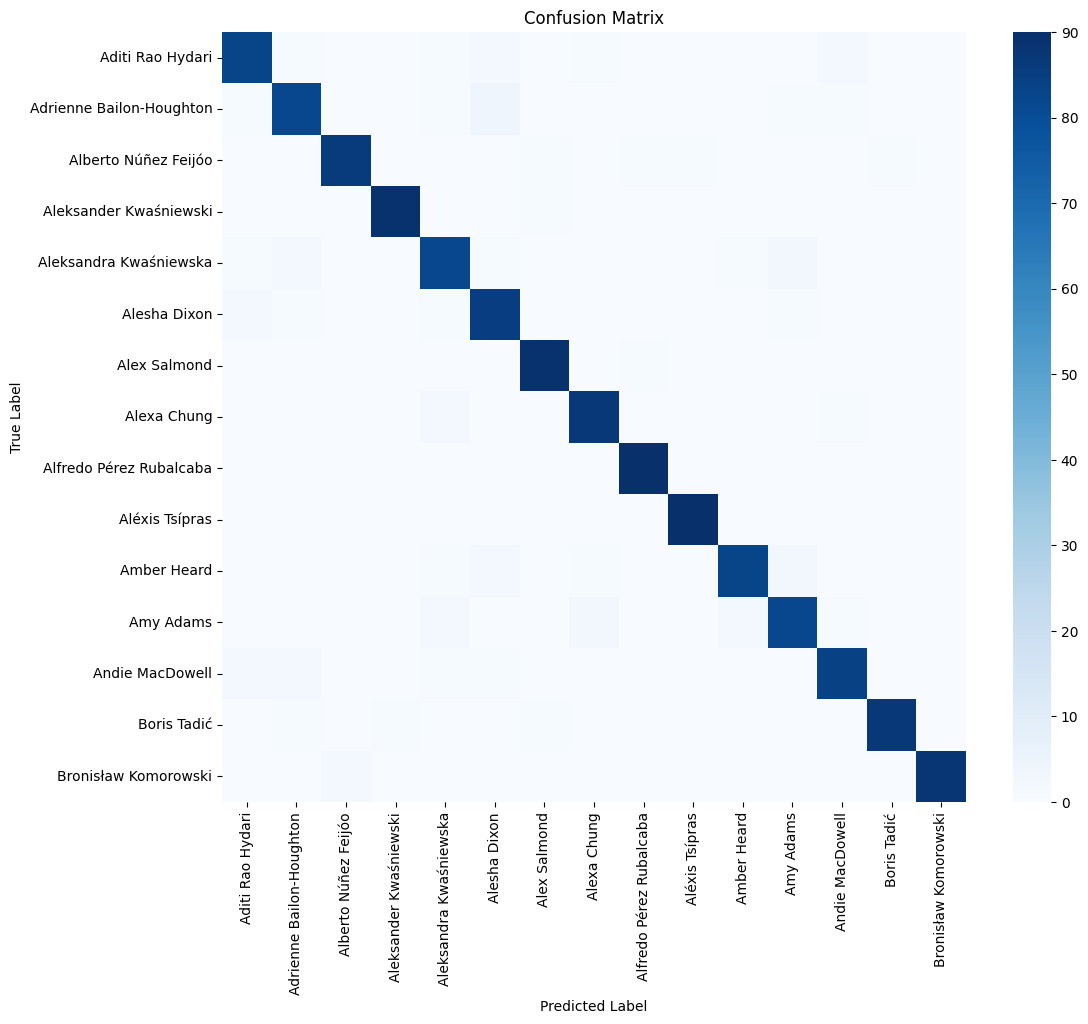

                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.93      0.92      0.93        90
Adrienne Bailon-Houghton       0.92      0.91      0.92        90
    Alberto Núñez Feijóo       0.98      0.96      0.97        90
  Aleksander Kwaśniewski       0.99      0.99      0.99        90
  Aleksandra Kwaśniewska       0.90      0.91      0.91        90
            Alesha Dixon       0.89      0.94      0.92        90
            Alex Salmond       0.97      0.99      0.98        90
             Alexa Chung       0.95      0.97      0.96        90
 Alfredo Pérez Rubalcaba       0.98      1.00      0.99        90
          Aléxis Tsípras       0.99      1.00      0.99        90
             Amber Heard       0.97      0.92      0.94        90
               Amy Adams       0.91      0.91      0.91        90
         Andie MacDowell       0.94      0.93      0.94        90
             Boris Tadić       0.99      0.97      0.98        90
    Broni

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get Predictions on Test Data
print("Generating predictions... (This might take a moment)")

# Reset the generator to start from the beginning
test_generator.reset()

# Predict probabilities for all test images
y_probs = model.predict(test_generator, verbose=1)

# Convert probabilities to class indices
y_pred = np.argmax(y_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 4. Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


Generating ROC curves...
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step


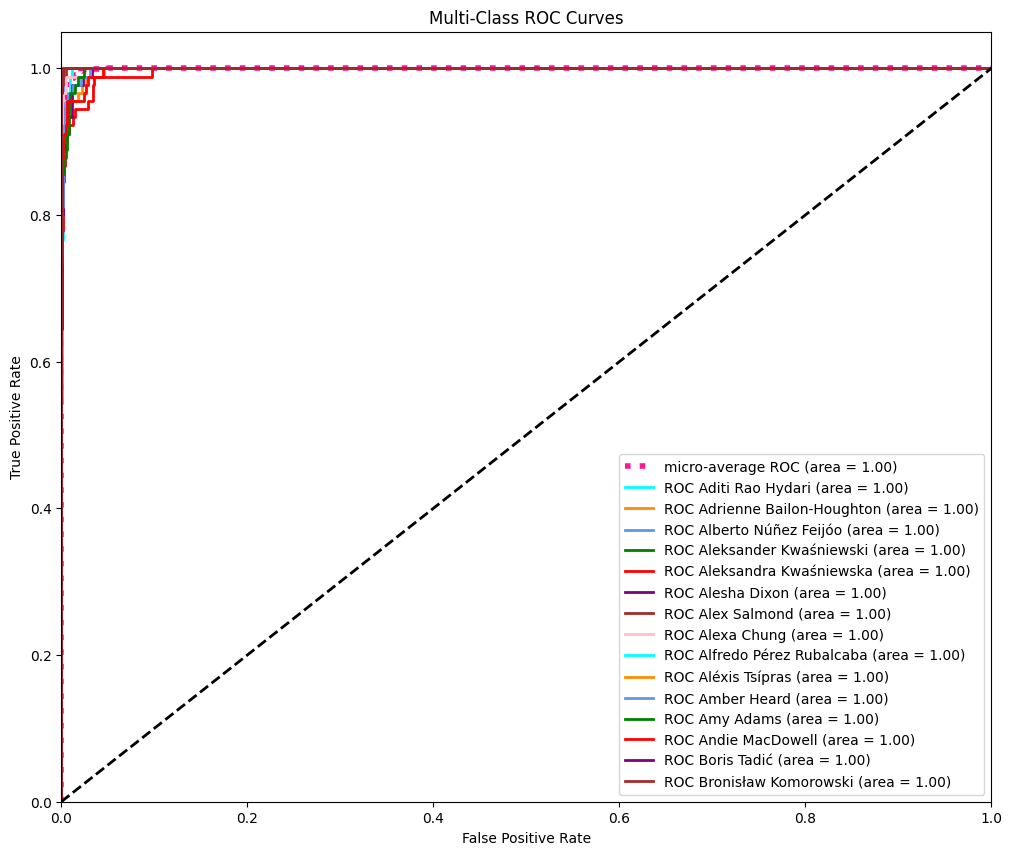

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("Generating ROC curves...")

# Reset the generator to start from the beginning
test_generator.reset()

# 1. Get predictions probabilities and true labels
y_probs = model.predict(test_generator, verbose=1)
y_true_indices = test_generator.classes

# 2. One-hot encode true labels
lb = LabelBinarizer()
lb.fit(range(len(class_names)))
y_true_bin = lb.transform(y_true_indices)

# 3. Compute ROC curve and AUC for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Plotting
plt.figure(figsize=(12, 10))

# Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Each class ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.show()
